In [1]:
import sys
sys.path.append('../')
from quantization.posttraining.layer_scale_optimization import *
from collections import namedtuple
from tqdm import tqdm
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from quantization.methods.clipped_uniform import L2NormQuantization, L3NormQuantization, AciqLaplaceQuantization

In [125]:
args_dict = {'arch': 'resnet18', 'custom_resnet': True, 'pretrained': True, 'dataset': 'imagenet', 'gpu_ids': [0], 'datapath': None,
                     'batch_size': 64, 'shuffle': True, 'workers': 25, 'print_freq': 10,
                     'cal_batch_size': 64, 'cal_set_size': 64}
args_dict['bit_act'] = 2
args_dict['bit_weights'] = None
args_dict['pre_relu'] = False
args_dict['qtype'] = 'max_static'
args = argparse.Namespace()
for k in args_dict:
    setattr(args, k, args_dict[k])
args

Namespace(arch='resnet18', batch_size=64, bit_act=2, bit_weights=None, cal_batch_size=64, cal_set_size=64, custom_resnet=True, datapath=None, dataset='imagenet', gpu_ids=[0], pre_relu=False, pretrained=True, print_freq=10, qtype='max_static', shuffle=True, workers=25)

In [126]:
if 'inf_model' in globals():
    del inf_model

# create model
# Always enable shuffling to avoid issues where we get bad results due to weak statistics
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)

all_layers = []
if args.bit_weights is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.Conv2d)][1:-1]
if args.bit_act is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU)][1:-1]
if args.bit_act is not None and 'mobilenet' in args.arch:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU6)][1:-1]
    
if 'mq' in globals():
    del mq

layers = all_layers # [all_layers[1], all_layers[2]]
replacement_factory = {nn.ReLU: ActivationModuleWrapperPost,
                       nn.ReLU6: ActivationModuleWrapperPost,
                       nn.Conv2d: ParameterModuleWrapperPost}
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)

In [127]:
loss = inf_model.evaluate_calibration()
print("loss: {:.4f}".format(loss.item()))

# get clipping values
init = get_clipping(mq)
# print(init)

init_ = init[0].new_empty(len(init))
for i in range(len(init)):
    init_[i] = init[i]
    
print(init_)

ActivationModuleWrapperPost - layer1.0.relu1 | MaxAbsStaticQuantization - [alpha: 3.8490, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.0.relu2 | MaxAbsStaticQuantization - [alpha: 6.5176, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.1.relu1 | MaxAbsStaticQuantization - [alpha: 3.9670, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.1.relu2 | MaxAbsStaticQuantization - [alpha: 13.9871, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer2.0.relu1 | MaxAbsStaticQuantization - [alpha: 5.5198, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer2.0.relu2 | MaxAbsStaticQuantization - [alpha: 11.6134, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer2.1.relu1 | MaxAbsStaticQuantization - [alpha: 5.9953, bits: 2, symmetric: False, tails: False, ] | cuda:0
Acti

In [104]:
def separability_index(f, m, n, gpu=False, gamma_expecation=True):
    x, z = torch.tensor(np.random.uniform(0, 1, size=(n, m))).float(), torch.tensor(np.random.uniform(0, 1, size=(n, m))).float()
    if gpu:
        x = x.cuda()
        z = z.cuda()

    print("Calaculate f(x)")
    t0 = f(x)
    print("Calaculate f(z)")
    t1 = t0 + (m - 1)*f(z)

    print("Calaculate f(xj,zj')")
    t2 = t1.new_zeros((n,))
    for i in range(m):
        y = z.clone()
        y[:,i] = x[:,i]
        t2 += f(y)

    g = t0 * (t1 - t2)
    gamma = g.mean()

    s = (g - gamma).std()
    T = np.sqrt(n) * gamma / max(s, 1e-8)

    if gamma_expecation:
        return gamma, T
    else:
        return g, T

# assum x is matrix (n,m) in range [0,1]
# n - number of sumples 
# m - number of variables
def model_func(x, scales):
    loss = x.new_empty(x.shape[0])
    for i in tqdm(range(x.shape[0])):
        # set clip value. rescale to [0.5,1] to avoid radical saturation
        r = (x[i] + 1) / 2
        set_clipping(mq, r*scales, inf_model.device)

        # evaluate with clipping
        loss[i] = inf_model.evaluate_calibration()
    return loss

  4%|▍         | 2/50 [00:00<00:03, 13.58it/s]

bits act: 8
Calaculate f(x)


  4%|▍         | 2/50 [00:00<00:02, 17.23it/s]

Calaculate f(z)


  4%|▍         | 2/50 [00:00<00:02, 17.25it/s]

Calaculate f(xj,zj')


100%|██████████| 50/50 [00:02<00:00, 17.01it/s]


gamma^2: -0.00282
T': -0.4046
T norm: -0.05721836
g: -0.1411


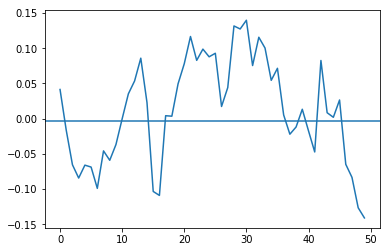

In [118]:
print("bits act: " + str(args_dict['bit_act']))
n = 50
gamma, T = separability_index(lambda x: model_func(x, init_), len(init_), n, gpu=True, gamma_expecation=False)
g = gamma.cpu().numpy()
g_cum = g.cumsum()
plt.plot(g_cum);
plt.axhline(g.mean())
print("gamma^2: {:.5f}".format(gamma.mean()))
print("T': {:.4f}".format(T))
print("T norm: {:.8f}".format(T / np.sqrt(n)))
print("g: {:.4f}".format(g.sum()))

  4%|▍         | 2/50 [00:00<00:03, 14.08it/s]

bits act: 4
Calaculate f(x)


  4%|▍         | 2/50 [00:00<00:02, 17.21it/s]

Calaculate f(z)


  4%|▍         | 2/50 [00:00<00:02, 17.19it/s]

Calaculate f(xj,zj')


100%|██████████| 50/50 [00:02<00:00, 16.91it/s]


gamma^2: 0.03523
T': 0.3287
T norm: 0.04648666
g: 1.7614


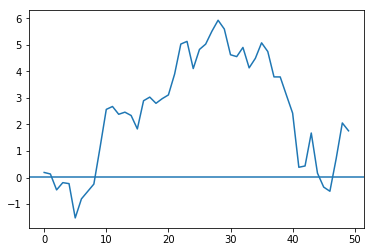

In [123]:
print("bits act: " + str(args_dict['bit_act']))
n = 50
gamma, T = separability_index(lambda x: model_func(x, init_), len(init_), n, gpu=True, gamma_expecation=False)
g = gamma.cpu().numpy()
g_cum = g.cumsum()
plt.plot(g_cum);
plt.axhline(g.mean())
print("gamma^2: {:.5f}".format(gamma.mean()))
print("T': {:.4f}".format(T))
print("T norm: {:.8f}".format(T / np.sqrt(n)))
print("g: {:.4f}".format(g.sum()))

  4%|▍         | 2/50 [00:00<00:03, 13.69it/s]

bits act: 2
Calaculate f(x)


  4%|▍         | 2/50 [00:00<00:02, 17.29it/s]

Calaculate f(z)


  4%|▍         | 2/50 [00:00<00:02, 17.35it/s]

Calaculate f(xj,zj')


100%|██████████| 50/50 [00:02<00:00, 16.98it/s]


gamma^2: 20.44934
T': 1.0199
T norm: 0.14423628
g: 1022.4673


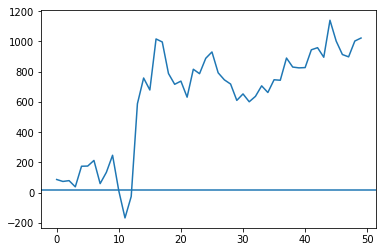

In [128]:
print("bits act: " + str(args_dict['bit_act']))
n = 50
gamma, T = separability_index(lambda x: model_func(x, init_), len(init_), n, gpu=True, gamma_expecation=False)
g = gamma.cpu().numpy()
g_cum = g.cumsum()
plt.plot(g_cum);
plt.axhline(g.mean())
print("gamma^2: {:.5f}".format(gamma.mean()))
print("T': {:.4f}".format(T))
print("T norm: {:.8f}".format(T / np.sqrt(n)))
print("g: {:.4f}".format(g.sum()))